In [226]:
import pandas as pd

df = pd.read_csv('UMCSENT(constant-daily).csv', index_col=0)
df2= pd.read_csv('UNRATE(constant-daily).csv', index_col=0)
df3 = pd.read_csv('sp500.csv', index_col=0)
df4 = pd.read_csv('dollar.csv', index_col=0)



In [ ]:
#Conncat the two metrics 
df3['20SMA'] = df3['Close'].rolling(20).mean()
df3['5SMA'] = df3['Close'].rolling(5).mean()
df3['Lag1'] = df3['Close'].shift(1)
df3['Lag2'] = df3['Close'].shift(2)
df3['Lag3'] = df3['Close'].shift(3)

In [231]:
#Set all data frames  to all start  at 2007-02-01	
df =   df[df.index>='2007-02-01']
df2 = df2[df2.index>='2007-02-01']
df3 = df3[df3.index>='2007-02-01']
df4 = df4[df4.index>='2007-02-01']

df =   df[df.index<='2023-11-01'  ]
df2 = df2[df2.index<='2023-11-01' ]
df3 = df3[df3.index<='2023-11-01' ]
df4 = df4[df4.index<='2023-11-01' ]
  

In [233]:
df3 = df3.drop(['High','Low'],axis=1)


In [234]:
df4 = df4.drop(df4.columns[1:],axis=1)
df4 = df4.rename(columns={'Open':'Dolar'})

In [235]:
#Drop the days from the weekend from data frame
df5= pd.read_csv('UNRATE(constant-daily).csv')
df5 = df5.rename(columns={'DATE':'Date'})
df5['Date'] = pd.to_datetime(df5['Date'])
df5 = df5[df5['Date'].dt.dayofweek < 5]
df5.to_csv('UNRATE(constant-daily).csv',index=False)

In [ ]:
import requests

url = 'https://www.alphavantage.co/query'
data = {
    "function": "TIME_SERIES_DAILY",
    "symbol": "USD",
    "apikey": "S1K44NG504AGCCZS"

        }
response = requests.get(url, params=data)
data = response.json()
data

In [236]:
df5 = pd.merge(df3,pd.merge(df4, pd.merge(df2, df, left_index=True, right_index=True), left_index=True, right_index=True), left_index=True, right_index=True)
df5.to_csv('dataset.csv')

In [238]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')





In [253]:
def loss_1(y, y_hat):
    correct = 0
    wrong = 0
    n = y.shape[0]
    for i in range(1,n):
        temp = y[i] - y[i-1]
        temp2 = y_hat[i] - y_hat[i-1]
        if temp>0:
            if temp2>0:
                correct+=1
            else:
                wrong+=1
        if temp<=0:
            if temp2<=0:
                correct+=1
            else:
                wrong+=1
    
    return correct/n

class NeuralNet(tf.keras.callbacks.Callback):
    def __init__(self,validation_data):
        super(NeuralNet, self).__init__()
        self.validation_data = validation_data
        self.max_error = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        predictions = self.model.predict(x_val)
        # Calculate the absolute errors\
        errors = loss_1(y_val, predictions)
        # Find and log the maximum error
        self.max_error.append(errors)
        print(f"Epoch {epoch + 1}, Accuracy : {errors}")

In [254]:
#Create the response and predictors variables
df = pd.read_csv('dataset.csv')
df = df.drop('Date',axis=1)
Y , X = df[df.columns[0]].to_numpy().reshape(-1,1) , df[df.columns[1:]].to_numpy()


In [244]:
#Normalize data

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
Y_scaled = scaler2.fit_transform(Y)


In [245]:
#Create test and train data sets
train_size = int(X_scaled.shape[0]*0.8)
test_size = X_scaled.shape[0] - train_size
trainY, testY = Y[60:train_size], Y[train_size:]



In [249]:
#Create windows of 60 days since we are using Recurent Neural Networks
# Reshape input to be  [samples, time steps, features]
trainX = []
for i in range(60, train_size):
    trainX.append(X[i-60:i,:])
trainX = np.array(trainX)

testX = []
test = X[train_size-60:, :]
for i in range(60, test_size):
    testX.append(test[i-60:i,:])

testX = np.array(testX)


In [250]:
trainX.shape

(3314, 60, 7)

In [252]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(trainX.shape[1],trainX.shape[2])))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(20 ,activation=tf.keras.activations.relu))
model.add(Dense(1))
error = NeuralNet(validation_data=(trainX,trainY))

model.compile(optimizer='adam', loss='mean_absolute_error')
history = model.fit(trainX,trainY, epochs=200, callbacks=[error] )

Epoch 1/200
104/104 [==============================] - 1s 5ms/step
Epoch 1, Accuracy : 0.4535304767652384
104/104 [==============================] - 5s 29ms/step - loss: 0.1416
Epoch 2/200
104/104 [==============================] - 1s 6ms/step
Epoch 2, Accuracy : 0.4471937235968618
104/104 [==============================] - 3s 27ms/step - loss: 0.1372
Epoch 3/200
104/104 [==============================] - 1s 5ms/step
Epoch 3, Accuracy : 0.452021726010863
104/104 [==============================] - 3s 27ms/step - loss: 0.1389
Epoch 4/200
104/104 [==============================] - 1s 5ms/step
Epoch 4, Accuracy : 0.44779722389861193
104/104 [==============================] - 3s 25ms/step - loss: 0.1377
Epoch 5/200
104/104 [==============================] - 1s 5ms/step
Epoch 5, Accuracy : 0.4462884731442366
104/104 [==============================] - 3s 26ms/step - loss: 0.1373
Epoch 6/200
104/104 [==============================] - 1s 5ms/step
Epoch 6, Accuracy : 0.44870247435123717
104/104 

KeyboardInterrupt: 

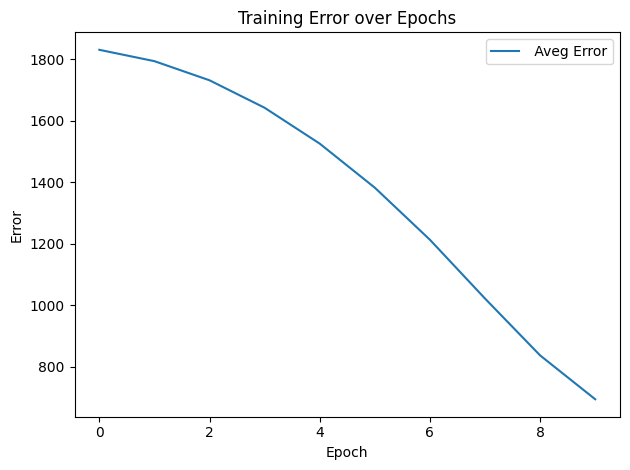

In [196]:
plt.plot(history.history['loss'], label = ' Aveg Error')

#plt.axhline(y=avg, color='blue', linestyle='--', label='Average Error')
#plt.axhline(y=maximum, color='red', linestyle='-', label='Max Error')
plt.title('Training Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.tight_layout()
plt.legend()  
plt.show()

In [6]:
import pandas as pd
df = pd.read_csv('stock.csv')
df2 = df.drop('Date', axis=1)
df2.corr()

KeyError: "['Date'] not found in axis"

In [58]:
test=scaled_data[train_size-60: , : ]

testX=[]
y_test=test[train_size:,0]
for i in range(60, len(test)):
    testX.append(test[i-60:i,1:])

testX = np.array(testX)

In [59]:
yhat = model.predict(testX)



29/29 [==============================] - 0s 9ms/step


In [63]:
testY.shape

(914,)

In [64]:
mean_squared_error(yhat,testY)

0.9056393850321464

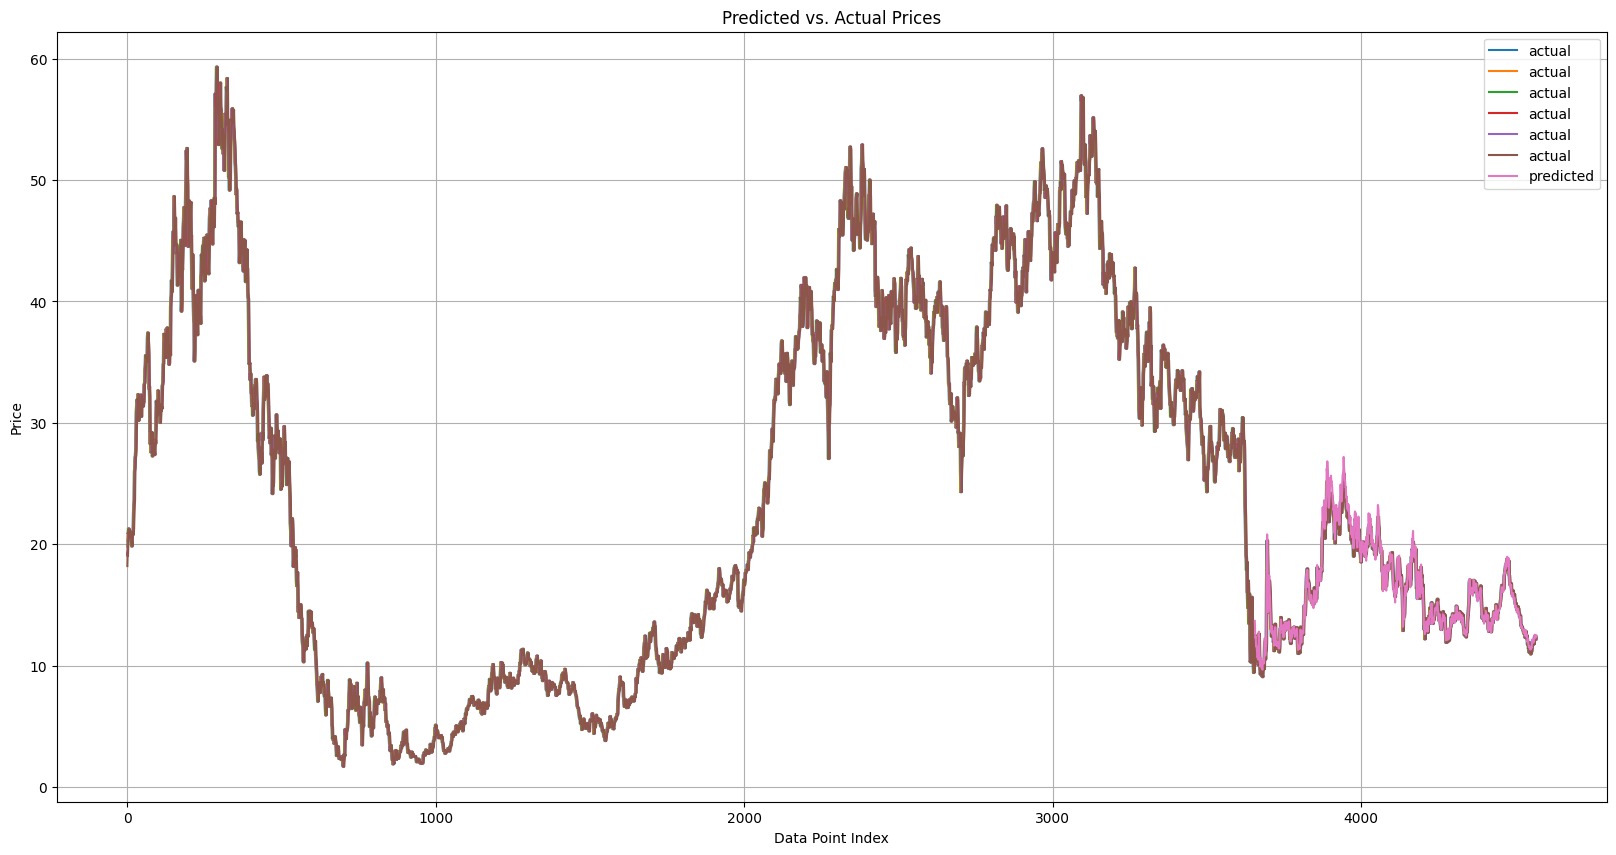

In [66]:
plt.figure(figsize=(20, 10))
plt.plot(range(0,len(scaled_data)), scaled_data, label="actual")
plt.plot(range(train_size, train_size+test_size), yhat , label = "predicted")

# Set plot labels and legend
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Data Point Index')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

In [73]:
df

,Date,Close,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag4_WTI,Lag5_WTI
0,2005-10-04,20.891155,20.268942,19.806992,19.052803,19.326202,18.194910,23.612602,23.589994
1,2005-10-05,20.928864,20.891155,20.268942,19.806992,19.052803,19.326202,24.230213,23.612602
2,2005-10-06,21.287100,20.928864,20.891155,20.268942,19.806992,19.052803,24.426043,24.230213
3,2005-10-07,20.881720,21.287100,20.928864,20.891155,20.268942,19.806992,22.588251,24.426043
4,2005-10-10,20.938284,20.881720,21.287100,20.928864,20.891155,20.268942,22.106211,22.588251
...,...,...,...,...,...,...,...,...,...
4564,2023-11-21,12.130000,12.400000,12.290000,12.190000,12.420000,12.250000,3.739003,3.838710
4565,2023-11-22,12.310000,12.130000,12.400000,12.290000,12.190000,12.420000,3.629326,3.739003
4566,2023-11-24,12.310000,12.310000,12.130000,12.400000,12.290000,12.190000,3.699120,3.629326
4567,2023-11-27,12.180000,12.310000,12.310000,12.130000,12.400000,12.290000,3.609384,3.699120
